Quora question pair

### 1. Business problem


## 1.1 description
Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

##1.2 constraints


1.   The cost of a mis-classification can be very high.
2.   You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.

1.   No strict latency concerns.
2.   Interpretability is partially important.






###PERFORMANCE METRICS
since we need probabilty of two question to be similar to be high so we will
use log loss as performance metric .

###2.  EDA


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

!pip install -q distance
!pip install -q fuzzywuzzy
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

##reading data

In [5]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [9]:
df = pd.read_csv("train.csv")
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


**as you can see there are 404289 nan in ques 1 and 404288 in ques 2 so there are 2 null vales in ques 2 and 1 in ques **


### distribution of data points amoung various class


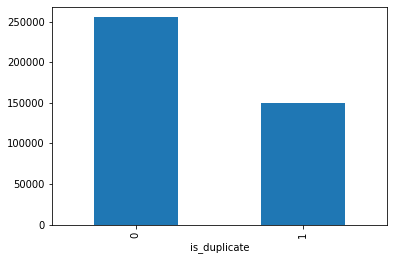

In [11]:
df.groupby("is_duplicate")['id'].count().plot.bar()

thus there are more diff ques(class 0) then similar ques(class 1)

finding uniques question in the data set

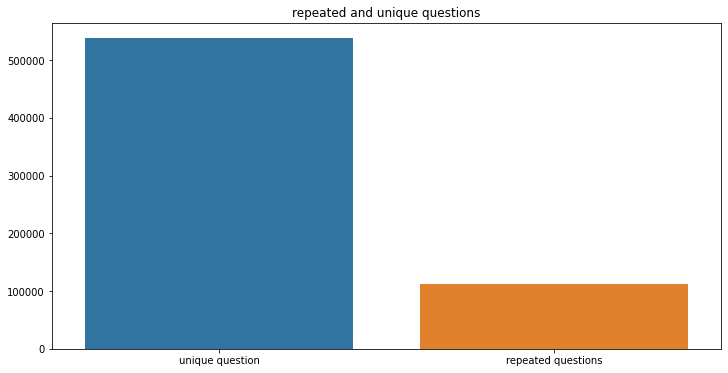

In [12]:
quesids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qid = len(np.unique(quesids))
repeated_qid = np.sum(quesids.value_counts()>1)
x = ["unique question","repeated questions"]
y = [unique_qid,repeated_qid]
plt.figure(figsize=(12,6))
plt.title("repeated and unique questions")
sns.barplot(x,y)
plt.show()

## checking for duplicated pairs 


In [13]:
pair_discrete = df.groupby(['qid1','qid2']).count().reset_index()
print(pair_discrete)
pair_dup = df.shape[0] - pair_discrete.shape[0]
print(pair_dup)

          qid1    qid2  id  question1  question2  is_duplicate
0            1       2   1          1          1             1
1            3       4   1          1          1             1
2            3  282170   1          1          1             1
3            3  380197   1          1          1             1
4            3  488853   1          1          1             1
...        ...     ...  ..        ...        ...           ...
404285  537924  537925   1          1          1             1
404286  537926  537927   1          1          1             1
404287  537928  537929   1          1          1             1
404288  537930  537931   1          1          1             1
404289  537932  537933   1          1          1             1

[404290 rows x 6 columns]
0


##occurance of each ques

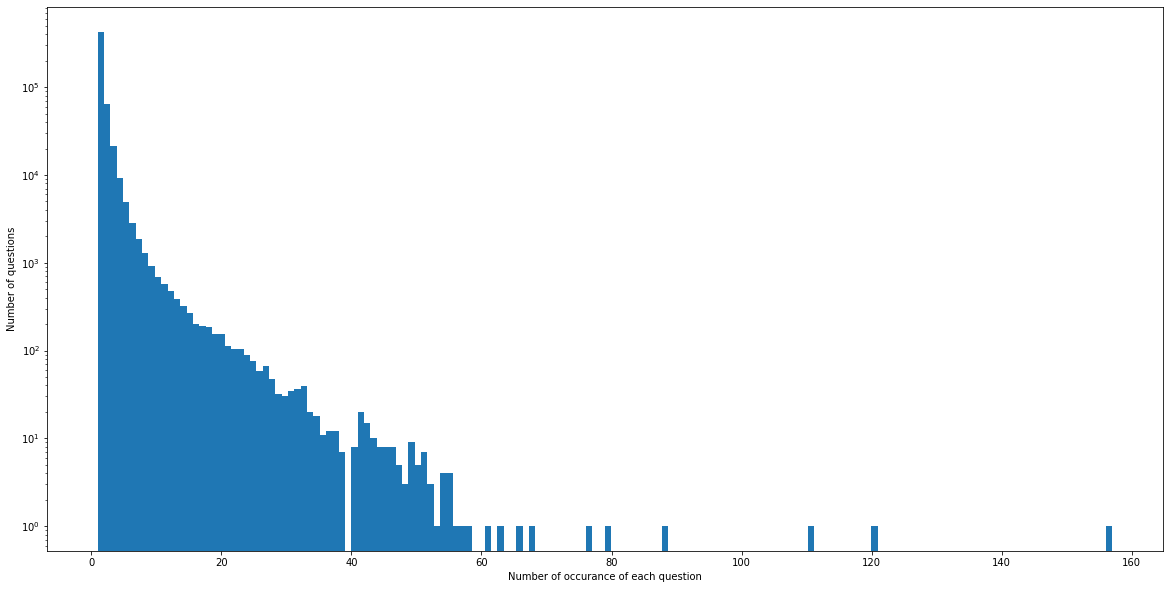

In [14]:
plt.figure(figsize=(20,10))
plt.hist(quesids.value_counts(),bins=160)
#plt.show()
# as y has large values so we take log histogram
plt.yscale('log', nonposy='clip')
plt.xlabel('Number of occurance of each question')
plt.ylabel('Number of questions')
plt.show()


as we saw above there were null values so correcting them

In [15]:
df = df.fillna('')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404290 non-null  object
 4   question2     404290 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### **Basic Features Extraction**

Let us now construct a few features like:

freq_qid1 = Frequency of qid1's

freq_qid2 = Frequency of qid2's

q1len = Length of q1

q2len = Length of q2

q1_n_words = Number of words in Question 1

q2_n_words = Number of words in Question 2

word_Common = (Number of common unique words in Question 1 and Question 2)

word_Total =(Total num of words in Question 1 + Total num of words in Question 2)

word_share = (word_common)/(word_Total)

freq_q1+freq_q2 = sum total of frequency of qid1 and qid2

freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [16]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row : len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row : len(row.split(" ")))
def find_common_words(row) :
  w1 = set(map(lambda word : word.lower().strip() , row['question1'].split(" ")))
  w2 = set(map(lambda word : word.lower().strip() , row['question2'].split(" ")))
  return 1.0*len(w1&w2)
df['word_common'] = df.apply(find_common_words , axis=1)
def total_word_count(row) :
  w1 = set(map(lambda word : word.lower().strip() , row['question1'].split(" ")))
  w2 = set(map(lambda word : word.lower().strip() , row['question2'].split(" ")))
  return 1.0*(len(w1)+len(w2))
df['word_total'] = df.apply(total_word_count,axis=1)
def word_share_count(row) :
  w1 = set(map(lambda word : word.lower().strip() , row['question1'].split(" ")))
  w2 = set(map(lambda word : word.lower().strip() , row['question2'].split(" ")))
  return 1.0 * (len(w1 & w2))/(len(w1)+len(w2))
df['word_share'] = df.apply(word_share_count,axis=1)
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


### Analysis of some extracted features

1.1 word share

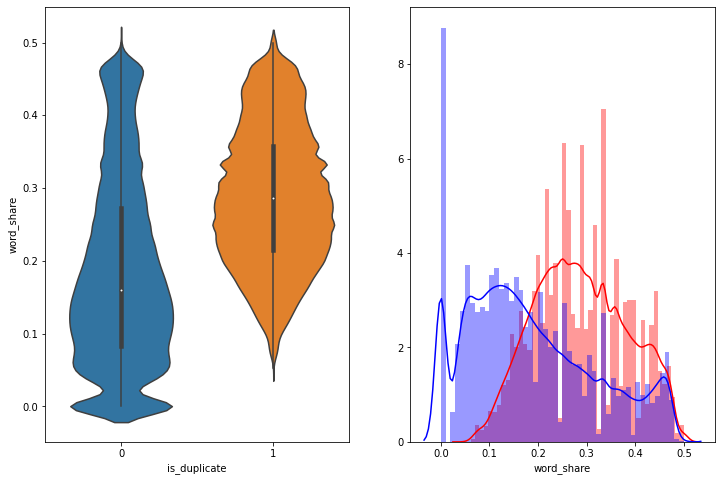

In [14]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate' , y='word_share' , data = df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_share'][0:] , label=1 , color='red')
sns.distplot(df[df['is_duplicate']==0.0]['word_share'][0:] , label=0 , color='blue')
plt.show()

so word share most what seperates the two classes

1.2 word common

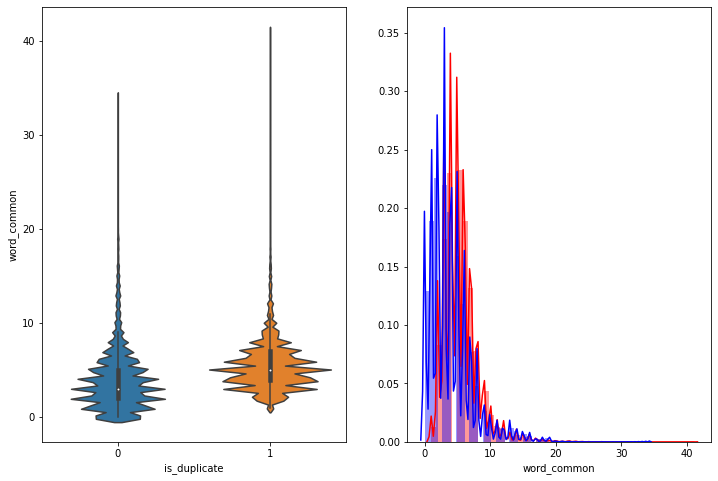

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='word_common' , data = df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_common'][0:] , label ='1' , color='red')
sns.distplot(df[df['is_duplicate']==0.0]['word_common'][0:] , label ='0' , color='blue')
plt.show()


here both classes heavily overlap so not much useful

###**Preprocessing of text**



1.   removing html tags
2.   removing punctuations
1.   Performing stemming
2.   removing stop words
1.   expanding contractions like m,k



*   standard preprocessing code



In [17]:
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words('english')

print(STOP_WORDS)
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

###**Advanced Features Extraction (NLP and Fuzzy Features)**

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [0]:
def get_token_features(q1,q2):
  #list for storing each of 10 features
  token_features = [0.0]*10
  q1_token = q1.split(" ")
  q2_token = q2.split(" ")
  if len(q1_token)==0 or len(q2_token)==0 :
    return token_features
  q1_word = set([word for word in q1_token if word not in STOP_WORDS])
  q2_word = set([word for word in q2_token if word not in STOP_WORDS])
  q1_stop = set([word for word in q1_token if word in STOP_WORDS])
  q2_stop = set([word for word in q2_token if word in STOP_WORDS])
  common_word_count = len(q1_word.intersection(q2_word))
  common_stop_count = len(q1_stop.intersection(q2_stop))
  common_token_count = len(set(q1_token).intersection(q2_token))
  token_features[0] = common_word_count / (min(len(q1_word), len(q2_word)) + SAFE_DIV)
  token_features[1] = common_word_count / (max(len(q1_word), len(q2_word)) + SAFE_DIV)
  token_features[2] = common_stop_count / (min(len(q1_stop), len(q2_stop)) + SAFE_DIV)
  token_features[3] = common_stop_count / (max(len(q1_stop), len(q2_stop)) + SAFE_DIV)
  token_features[4] = common_token_count / (min(len(q1_token), len(q2_token)) + SAFE_DIV)
  token_features[5] = common_token_count / (max(len(q1_token), len(q2_token)) + SAFE_DIV)
  token_features[6] = int(q1_token[-1] == q2_token[-1])
  token_features[7] = int(q1_token[0] == q2_token[0])
  token_features[8] = abs(len(q1_token) - len(q2_token))
  token_features[9] = (len(q1_token) + len(q2_token))/2
  return token_features
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
def extract_features(df):
  df['question1'] = df['question1'].apply(preprocess)
  df['question2'] = df['question2'].apply(preprocess)
  features = df.apply(lambda x : get_token_features(x['question1'] , x['question2']) , axis=1)
  df["cwc_min"]       = list(map(lambda x: x[0], features))
  df["cwc_max"]       = list(map(lambda x: x[1], features))
  df["csc_min"]       = list(map(lambda x: x[2], features))
  df["csc_max"]       = list(map(lambda x: x[3], features))
  df["ctc_min"]       = list(map(lambda x: x[4], features))
  df["ctc_max"]       = list(map(lambda x: x[5], features))
  df["last_word_eq"]  = list(map(lambda x: x[6], features))
  df["first_word_eq"] = list(map(lambda x: x[7], features))
  df["abs_len_diff"]  = list(map(lambda x: x[8], features))
  df["mean_len"]      = list(map(lambda x: x[9], features))
  df["fuzz_ratio"] = df.apply(lambda x : fuzz.QRatio(x['question1'],x['question2']) ,axis=1)
  df["fuzz_partial_ratio"] = df.apply(lambda x : fuzz.partial_ratio(x['question1'],x['question2']) ,axis=1)
  df["token_sort_ratio"] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'],x['question2']) ,axis=1)
  df["token_set_ratio"] = df.apply(lambda x : fuzz.token_set_ratio(x['question1'],x['question2']) ,axis=1)
  df["longest_substr_ratio"] = df.apply(lambda x : get_longest_substr_ratio(x['question1'] , x['question2']) , axis=1)
  return df


In [19]:
# calling the extract features function
#df = extract_features(df)
#df2 = df[0:100000]
#df2 = extract_features(df2)
#df2.head(3)
df = extract_features(df)
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999983,0.857131,0.999983,0.999983,0.923070,0.799995,1,1,2,14.0,93,100,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.833319,0.454541,0.749981,0.599988,0.615380,0.444442,1,1,5,15.5,66,75,63,86,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.499992,0.428565,0.399992,0.249997,0.454541,0.333331,1,1,4,13.0,43,47,63,63,0.166667


### Analysis of extracted features

Plotting word cloud for duplicate and non duplicate words


In [19]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [20]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
stopwords.remove("like")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


Word Cloud for non-Duplicate Question pairs:


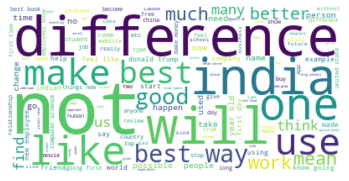

In [21]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Duplicate Question pairs


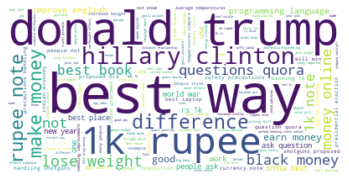

In [22]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

since some words occur alot in duplicate class this could be useful

now we will use pair plot on some of the features to understand bi-gram nature of features

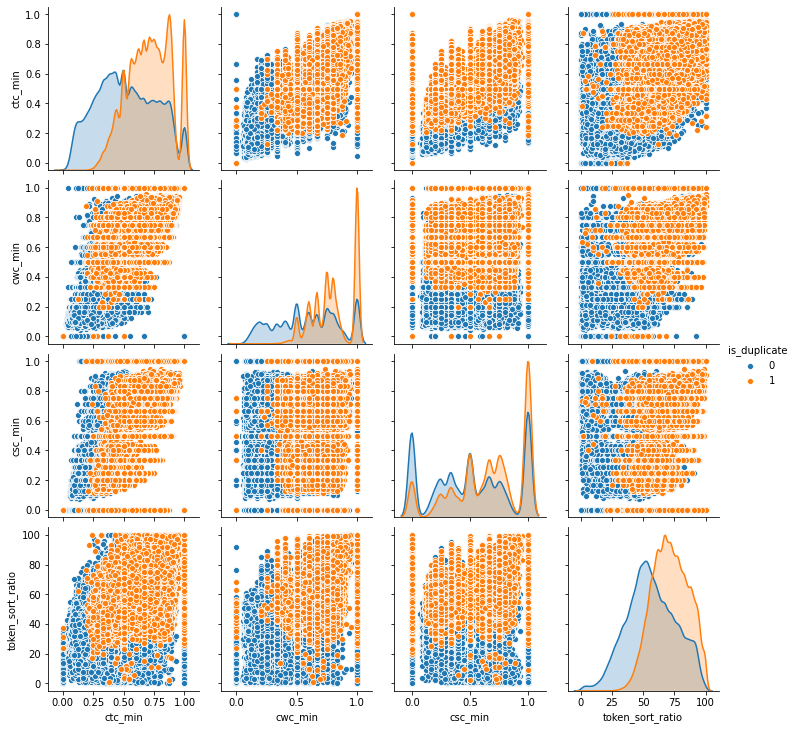

In [23]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

**even though there is interaction between classes of pts but still there are some parts where classes 1 and 0 are seperated**

###Visualization

In [24]:
#using tsne visualizing a 15 features dataset into a 2 dimention plot
from sklearn.preprocessing import MinMaxScaler
 #min max scaler converts the number to a no between 0 to 1 by xnew = x-min/max-min
df_subsample = df[0:5000]
X = MinMaxScaler().fit_transform(df_subsample[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
Y = df_subsample['is_duplicate'].values

from sklearn.manifold import TSNE
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.039s...
[t-SNE] Computed neighbors for 5000 samples in 0.604s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.118704
[t-SNE] Computed conditional probabilities in 0.320s
[t-SNE] Iteration 50: error = 82.8709869, gradient norm = 0.0365366 (50 iterations in 2.451s)
[t-SNE] Iteration 100: error = 73.4320831, gradient norm = 0.0061906 (50 iterations in 1.708s)
[t-SNE] Iteration 150: error = 72.3568726, gradient norm = 0.0050076 (50 iterations in 1.832s)
[t-SNE] Iteration 200: error = 71.9173126, gradient norm = 0.0027693 (50 iterations in 1.885s)
[t-SNE] Iteration 250: error = 71.6603394, gradient norm = 0.0024579

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



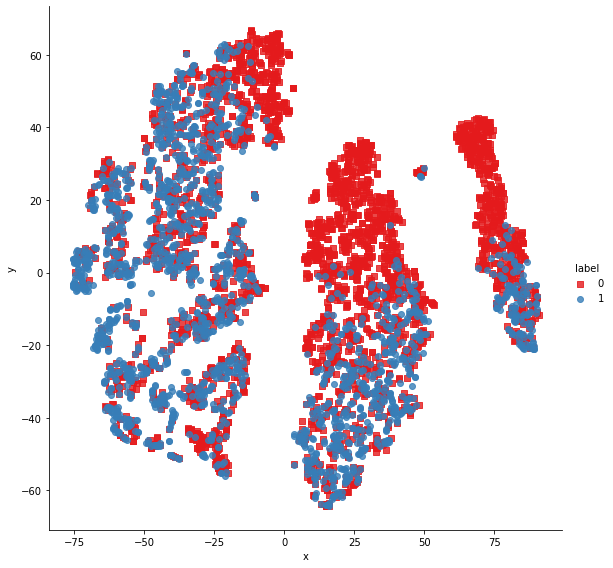

In [25]:
df_reduced= pd.DataFrame({'x': tsne2d[:,0] , 'y': tsne2d[:,1] , 'label': Y})
#df_reduced.head(3)
sns.lmplot(data=df_reduced, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.show()

### featurising text data using tfidf weighted word2vec

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
!pip install spacy

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy
nlp = spacy.load("en_core_web_sm")

In [0]:
df['question1'] = df['question1'].apply(lambda x : str(x))
df['question2'] = df['question2'].apply(lambda x : str(x))



*   now after getting tfidf score we convert each question to a weighted average of word2vec vectors by these scores.

*   here we use a pre-trained GLOVE model which comes free
 with "Spacy". https://spacy.io/usage/vectors-similarity
 
*   It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.





In [0]:
#taking random 1lack points as below processes take alot of time
df = df.sample(n=100000)

In [0]:

df2 = df

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df2['question2'])
questions = questions + list(df2['question1'])
tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))


In [24]:
print(word2tfidf['android'])

6.240997299916267


In [25]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df2['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    row = len(doc1)
    col = 0
    if(row > 0) : col = len(doc1[0].vector)
    mean_vec1 = np.zeros([row,col])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df2['q1_feats_m'] = list(vecs1)


100%|██████████| 100000/100000 [14:27<00:00, 115.26it/s]


In [26]:
nlp1 = spacy.load('en_core_web_sm')
vecs2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu2 in tqdm(list(df2['question2'])):
    doc2 = nlp1(qu2) 
    # 384 is the number of dimensions of vectors 
    row = len(doc2)
    col = 0
    if(row > 0) : col = len(doc2[0].vector)
    mean_vec2 = np.zeros([row,col])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df2['q2_feats_m'] = list(vecs2)

100%|██████████| 100000/100000 [14:51<00:00, 112.12it/s]


In [27]:

df2.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m
287766,287766,7023,16073,what is the best beginner friendly book on pyt...,which is the best book for learning python for...,1,8,13,50,79,9,14,5.0,22.0,0.227273,21,5,0.666656,0.571420,0.749981,0.428565,0.699993,0.466664,1,0,5,12.5,49,60,65,70,0.274510,"[-9.990231990814209, -50.209046602249146, 6.97...","[42.651982605457306, -90.32824464142323, 13.29..."
334316,334316,461480,416864,how does whatsapp earn money,how does whatsapp make money please see detai...,0,1,2,29,55,5,9,4.0,14.0,0.285714,3,1,0.749981,0.374995,0.999950,0.999950,0.833319,0.454541,1,1,5,8.5,61,90,62,90,0.600000,"[-13.588248878717422, -32.43925762176514, -13....","[-47.14402395486832, 33.42902600765228, -65.20..."
114970,114970,80779,36806,why do i always get a notification from quora ...,why does quora keep marking my questions as n...,1,1,11,83,66,14,10,5.0,24.0,0.208333,12,10,0.571420,0.499994,0.499988,0.285710,0.461535,0.352939,1,1,4,15.0,63,73,66,70,0.208955,"[27.140657126903534, 39.17909288406372, 26.783...","[95.84855546057224, 13.742066979408264, -73.37..."
21338,21338,40189,40190,how can i decrease my abs definition,my abs are so much defined how can i reduce t...,1,1,1,37,60,7,12,6.0,19.0,0.315789,2,0,0.749981,0.499992,0.999975,0.571420,0.874989,0.499996,1,0,6,11.0,53,75,66,86,0.315789,"[-3.0375572443008423, -4.953543186187744, -16....","[45.92421269416809, 29.36364221572876, -5.5914..."
180857,180857,277192,277193,is it ok to marry my father own brother own da...,my father just recently got married his wife ...,0,1,1,49,124,9,24,3.0,31.0,0.096774,2,0,0.499992,0.249998,0.599988,0.272725,0.499996,0.222221,1,0,15,19.5,30,45,49,67,0.185185,"[-4.5592135190963745, -32.182618260383606, -91...","[39.00113236904144, 41.1861846446991, 60.03535..."


In [0]:
# storing the final features to csv file
#if not os.path.isfile('final_features.csv'):
#  df.to_csv('final_features.csv')


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

###Converting strings to numerics and tfidf weighted w2v vectors into seperate features

In [29]:
data_q1 = df2[['id','q1_feats_m']]
data_q1.head()

,id,q1_feats_m
287766,287766,"[-9.990231990814209, -50.209046602249146, 6.97..."
334316,334316,"[-13.588248878717422, -32.43925762176514, -13...."
114970,114970,"[27.140657126903534, 39.17909288406372, 26.783..."
21338,21338,"[-3.0375572443008423, -4.953543186187744, -16...."
180857,180857,"[-4.5592135190963745, -32.182618260383606, -91..."


In [30]:
data_q2 = df2[['id','q2_feats_m']]
data_q2.head()

,id,q2_feats_m
287766,287766,"[42.651982605457306, -90.32824464142323, 13.29..."
334316,334316,"[-47.14402395486832, 33.42902600765228, -65.20..."
114970,114970,"[95.84855546057224, 13.742066979408264, -73.37..."
21338,21338,"[45.92421269416809, 29.36364221572876, -5.5914..."
180857,180857,"[39.00113236904144, 41.1861846446991, 60.03535..."


In [31]:
data_q1 = pd.DataFrame(data_q1.q1_feats_m.values.tolist(), index = data_q1.index)
data_q1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
287766,-9.990232,-50.209047,6.972735,60.057218,81.759339,50.992652,-27.599988,48.641048,19.281026,122.545773,67.062358,-35.320461,29.748755,-5.610072,-60.730231,-46.129429,-64.109694,5.097512,-65.777133,-37.658383,20.894158,-59.304341,51.980445,6.998612,-45.982381,17.423735,-30.079628,-62.302300,60.289446,-57.768825,-40.472482,-30.312015,-1.691147,-24.734121,-17.712935,-77.714111,81.670790,-62.531401,-49.584594,-7.505978,...,-0.695278,37.933198,7.998969,-9.641281,2.699516,-92.711068,37.225767,-37.743195,41.422909,2.359188,70.299385,-34.705022,-7.292426,27.614960,-24.497874,-3.779419,-12.493058,39.705976,-12.742455,-18.091238,42.649603,-29.374380,-5.320275,41.028903,0.636359,-77.517047,-3.594970,-11.646815,75.388339,80.504941,-53.064281,-24.915714,24.038322,21.127721,-42.410828,-18.931761,33.583297,59.402534,13.832224,15.246031
334316,-13.588249,-32.439258,-13.264320,13.542263,48.990134,35.469818,24.584359,-5.873683,40.772056,49.167799,45.970115,-8.527854,39.071262,-64.258479,7.588771,13.494426,-3.951032,-14.052077,-24.864365,-28.099905,18.667067,11.000741,-21.666026,-1.627346,0.204226,-7.787780,43.420078,-28.488428,20.376122,-29.282892,-0.349792,23.088998,23.402992,-30.141272,7.141082,-3.515190,48.005265,-18.110009,-31.421736,-18.135572,...,87.406197,24.611872,-36.232225,-24.949808,47.177086,-34.385105,-21.242713,-10.861543,-2.752171,-42.607000,-0.395265,18.776074,-16.777585,-23.450432,-18.727441,78.958339,35.743096,21.274805,-38.747440,-22.047004,-4.069400,-30.755055,19.400058,26.352322,-3.991946,16.441545,-45.313004,41.135092,33.477443,6.757504,-15.379641,-15.259449,-6.556984,-12.500283,6.274964,1.984985,-28.777323,8.293764,0.732852,19.374172
114970,27.140657,39.179093,26.783102,-61.309108,1.568831,17.982947,34.484068,51.521549,73.933354,149.518942,7.862737,3.670771,-4.372546,-44.670558,39.523148,20.045950,-14.788334,-12.360803,-5.002046,0.007571,-29.146367,72.400842,-81.476003,-34.364194,-20.141425,44.570200,-74.030353,-85.155198,54.606861,-63.158009,41.086569,-15.034742,15.814669,-80.455930,1.727663,-45.149730,57.095451,-55.677944,-99.971564,9.840669,...,69.533336,74.736386,-18.860716,68.551063,91.738095,-53.662595,30.867983,-13.189090,60.151870,-32.868836,73.906063,-61.668046,-39.361172,36.490941,-39.222279,15.200717,102.579493,-4.656174,-44.749434,13.742443,92.501037,-47.895314,-33.518804,-40.624676,-42.429573,-15.350631,-56.675687,55.840010,22.611488,-38.577220,37.212507,-27.068196,-67.766166,53.657878,-28.454488,-16.727426,-68.035982,47.623098,25.711726,29.741903
21338,-3.037557,-4.953543,-16.755488,-39.787977,14.284707,51.704210,1.655211,15.147411,75.950309,105.407166,30.980313,-28.202211,9.669097,-30.728863,39.485692,26.974619,-1.662140,-11.102532,10.340659,-33.562936,32.809709,-9.793411,-31.759405,-45.719095,-8.487487,23.044752,21.527404,-70.757572,23.747555,8.348525,25.466088,54.307909,7.420980,6.606113,-9.368561,-46.452818,24.113874,-17.187794,-86.513485,-23.385873,...,68.940161,39.454594,-67.394767,64.507403,70.661236,-52.343894,-66.963365,33.263239,-3.795585,-13.684106,76.682435,7.095673,-33.647837,23.503130,-10.644931,49.536414,43.645968,31.918792,-81.455252,-30.445152,23.012022,-38.874898,-9.600785,34.119805,-2.690183,-17.898555,-42.387878,50.576247,16.797557,14.330156,21.192893,42.339992,-11.419287,-29.017849,-4.462254,9.077408,-97.320018,55.033428,12.110559,-2.242500
180857,-4.559214,-32.182618,-91.834698,1.013607,33.156562,36.422646,22.328944,104.110879,109.878368,96.669209,88.126709,-37.070614,117.340320,-74.686445,-15.221479,26.034819,-70.337896,-29.330906,-74.098642,-28.748177,-26.885522,-64.949438,-22.741485,6.511712,-78.335406,0.707906,88.729168,-63.394765,47.812466,-57.885164,38.960846,6.269229,-41.711702,-110.296299,39.326285,-126.769116,84.995581,-94.066533,-90.196719,

In [32]:
data_q2 = pd.DataFrame(data_q2.q2_feats_m.values.tolist(),index = data_q2.index)
data_q2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
287766,42.651983,-90.328245,13.294285,107.496206,73.888526,65.711497,-9.113473,-1.478593,83.183151,60.079089,13.022626,27.586522,-17.645867,-68.979537,-70.266224,-34.375583,-121.098058,6.307798,-18.467788,-66.486492,40.632314,-35.204595,-17.626174,-9.573494,-31.961703,-17.265696,-118.625831,21.285007,18.632994,-67.013106,71.854586,-14.581921,-10.094924,-77.238318,-23.398531,-79.466317,78.625500,-10.844967,-98.634531,6.959095,...,24.927840,115.692652,-11.257542,35.167449,86.339772,-47.127252,55.713044,46.280628,39.335796,-2.338663,102.095446,-53.210485,6.061259,20.009521,-43.947432,-70.821983,25.933460,49.627832,39.530211,4.466555,19.749371,-96.915824,-30.777468,61.539784,-6.482132,-18.749807,-28.967582,-26.472461,74.404550,66.786719,-85.988972,-39.872202,-42.231121,106.831840,-1.825911,-53.458399,78.610086,71.089630,17.338038,82.809770
334316,-47.144024,33.429026,-65.209872,-44.203000,74.580042,61.828175,55.837658,12.877756,142.923568,83.200583,25.320209,-27.728438,123.581191,-2.460574,59.256496,33.165717,-4.910433,-19.370468,10.210605,-43.875271,-19.476797,27.774430,-100.996643,-12.092424,89.272567,9.113933,55.187935,-106.004999,31.453698,-35.316482,17.949236,13.973589,-29.732080,-22.741981,74.579799,48.483500,122.927456,-37.452228,-83.297256,33.218850,...,134.600302,50.869611,-31.481074,-27.677593,95.832148,-2.951482,-37.574067,-48.652236,22.468997,-82.479349,56.110909,12.804011,31.461220,1.361725,-6.431773,102.758576,7.054696,33.080257,-54.969888,-36.883295,23.356188,2.701064,-45.133357,72.487839,-33.334216,-19.002383,-75.322064,23.832167,7.901616,-36.023915,-69.520354,-0.773320,-48.283581,27.969895,25.528556,3.479003,-42.451264,46.526145,-5.912483,38.968466
114970,95.848555,13.742067,-73.378131,44.142767,27.133132,-34.887740,61.441393,65.547896,57.813195,78.868159,0.759550,-54.826014,103.224320,-63.022586,-19.084759,9.097937,-10.694698,24.929245,7.973751,-52.910040,-48.616242,54.888952,-24.932473,45.616998,-42.492157,-4.029093,-8.753242,-18.423267,-15.389186,-24.267108,75.797153,62.855332,29.708830,-75.365178,23.407207,-62.090159,9.727796,-56.236278,-197.905235,-8.987029,...,56.336606,101.905341,65.028457,16.268888,165.553399,-82.095414,6.120582,43.993280,31.222455,-34.020636,12.415705,-115.951499,-29.699117,95.361589,-44.677778,-139.523960,82.102743,24.360440,-34.841789,6.241631,71.284118,-148.800931,-60.266773,-22.095807,-33.318665,5.376296,-55.958236,-32.882287,62.232322,1.346794,12.894038,-39.818020,-38.819267,85.913468,-54.755549,-66.482695,-20.381636,66.457722,40.965521,27.256822
21338,45.924213,29.363642,-5.591489,-33.457983,63.858311,13.807373,86.419125,36.909357,-21.627064,96.431146,-71.661029,7.678075,63.814843,-30.870863,23.152327,74.893028,-26.715589,-5.706172,35.569594,5.992669,14.238834,5.996517,-117.554873,-16.463962,7.446820,44.319225,-78.712052,-40.525247,56.376651,-26.319864,32.373530,41.235634,-22.890815,-57.716890,-58.692607,-64.623959,48.126188,-45.132195,-76.978271,-9.931070,...,72.739650,31.823624,-28.988926,80.023030,102.785325,-51.451786,-16.457244,-17.020142,83.807380,-72.482488,78.993757,-6.307381,-33.340806,36.913819,-64.211837,64.729447,137.239566,19.763620,-32.888604,-10.256081,85.245733,-30.903989,-45.132913,11.592269,-51.121108,-85.994562,85.991066,87.387543,-73.577899,-6.428505,-41.933029,62.101055,0.143242,-31.043306,-15.974099,-17.139315,-67.311390,39.855818,-28.287727,1.221630
180857,39.001132,41.186185,60.035355,131.325147,197.819609,113.032299,144.143827,9.523854,161.681489,358.456239,-88.678570,35.350839,-58.927761,-95.274794,-85.241851,-53.585154,-59.651382,-55.117711,-233.618692,-42.822471,40.614314,-39.619184,-42.017874,-93.816936,-148.341131,50.196296,-60.676289,-13.173763,70.164979,-159.435536,160.718091,128.524036,-54.641389,-119.154975,77.837300,-

In [33]:
df2 = df2.drop(['question1','question2'],axis=1)
data_q1['id'] = df2['id']
data_q2['id'] = df2['id']
df2 = df2.merge(data_q1,on='id',how='left')
df2 = df2.merge(data_q2,on='id',how='left')
df2.head()

,id,qid1,qid2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,287766,7023,16073,1,8,13,50,79,9,14,5.0,22.0,0.227273,21,5,0.666656,0.571420,0.749981,0.428565,0.699993,0.466664,1,0,5,12.5,49,60,65,70,0.274510,"[-9.990231990814209, -50.209046602249146, 6.97...","[42.651982605457306, -90.32824464142323, 13.29...",-9.990232,-50.209047,6.972735,60.057218,81.759339,50.992652,-27.599988,48.641048,...,24.927840,115.692652,-11.257542,35.167449,86.339772,-47.127252,55.713044,46.280628,39.335796,-2.338663,102.095446,-53.210485,6.061259,20.009521,-43.947432,-70.821983,25.933460,49.627832,39.530211,4.466555,19.749371,-96.915824,-30.777468,61.539784,-6.482132,-18.749807,-28.967582,-26.472461,74.404550,66.786719,-85.988972,-39.872202,-42.231121,106.831840,-1.825911,-53.458399,78.610086,71.089630,17.338038,82.809770
1,334316,461480,416864,0,1,2,29,55,5,9,4.0,14.0,0.285714,3,1,0.749981,0.374995,0.999950,0.999950,0.833319,0.454541,1,1,5,8.5,61,90,62,90,0.600000,"[-13.588248878717422, -32.43925762176514, -13....","[-47.14402395486832, 33.42902600765228, -65.20...",-13.588249,-32.439258,-13.264320,13.542263,48.990134,35.469818,24.584359,-5.873683,...,134.600302,50.869611,-31.481074,-27.677593,95.832148,-2.951482,-37.574067,-48.652236,22.468997,-82.479349,56.110909,12.804011,31.461220,1.361725,-6.431773,102.758576,7.054696,33.080257,-54.969888,-36.883295,23.356188,2.701064,-45.133357,72.487839,-33.334216,-19.002383,-75.322064,23.832167,7.901616,-36.023915,-69.520354,-0.773320,-48.283581,27.969895,25.528556,3.479003,-42.451264,46.526145,-5.912483,38.968466
2,114970,80779,36806,1,1,11,83,66,14,10,5.0,24.0,0.208333,12,10,0.571420,0.499994,0.499988,0.285710,0.461535,0.352939,1,1,4,15.0,63,73,66,70,0.208955,"[27.140657126903534, 39.17909288406372, 26.783...","[95.84855546057224, 13.742066979408264, -73.37...",27.140657,39.179093,26.783102,-61.309108,1.568831,17.982947,34.484068,51.521549,...,56.336606,101.905341,65.028457,16.268888,165.553399,-82.095414,6.120582,43.993280,31.222455,-34.020636,12.415705,-115.951499,-29.699117,95.361589,-44.677778,-139.523960,82.102743,24.360440,-34.841789,6.241631,71.284118,-148.800931,-60.266773,-22.095807,-33.318665,5.376296,-55.958236,-32.882287,62.232322,1.346794,12.894038,-39.818020,-38.819267,85.913468,-54.755549,-66.482695,-20.381636,66.457722,40.965521,27.256822
3,21338,40189,40190,1,1,1,37,60,7,12,6.0,19.0,0.315789,2,0,0.749981,0.499992,0.999975,0.571420,0.874989,0.499996,1,0,6,11.0,53,75,66,86,0.315789,"[-3.0375572443008423, -4.953543186187744, -16....","[45.92421269416809, 29.36364221572876, -5.5914...",-3.037557,-4.953543,-16.755488,-39.787977,14.284707,51.704210,1.655211,15.147411,...,72.739650,31.823624,-28.988926,80.023030,102.785325,-51.451786,-16.457244,-17.020142,83.807380,-72.482488,78.993757,-6.307381,-33.340806,36.913819,-64.211837,64.729447,137.239566,19.763620,-32.888604,-10.256081,85.245733,-30.903989,-45.132913,11.592269,-51.121108,-85.994562,85.991066,87.387543,-73.577899,-6.428505,-41.933029,62.101055,0.143242,-31.043306,-15.974099,-17.139315,-67.311390,39.855818,-28.287727,1.221630
4,180857,277192,277193,0,1,1,49,124,9,24,3.0,31.0,0.096774,2,0,0.499992,0.249998,0.599988,0.272725,0.499996,0.222221,1,0,15,19.5,30,45,49,67,0.185185,"[-4.5592135190963745, -32.182618260383606, -91...","[39.00113236904144, 41.1861846446991, 60.03535...",-4.559214,-32.182618,-91.834698,1.013607,33.156562,36.422646,22.328944,104.110879,...,132.082537,-64.168255,97.568605,-76.438433,99.179307,-166.311494,137.2949

In [0]:
df3 = df2
#spliting the data into xi's and yi's
y_true = df3['is_duplicate']
x_true = df3.drop(['is_duplicate','q1_feats_m','q2_feats_m'],axis=1)

### RANDOM SPLIT TEST AND TRAIN DATASET(70:30)

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x_true, y_true , stratify=y_true , test_size = 0.3 )

In [36]:
print("Number of data points in train data :",x_train.shape)
print("Number of data points in test data :",x_test.shape)

Number of data points in train data : (70000, 221)
Number of data points in test data : (30000, 221)


####function to build confusion matrix , recall matrix and precision matrix for our model 

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

#Building a random model (calculating worst log loss possible)

### as we know that a dumb model that predicts y_i_hat randomly without using x_i or any model is the worst model possible and thus whatever model we train must have a log loss less than this random model

Log loss on Test Data using Random Model 0.8855257178330365


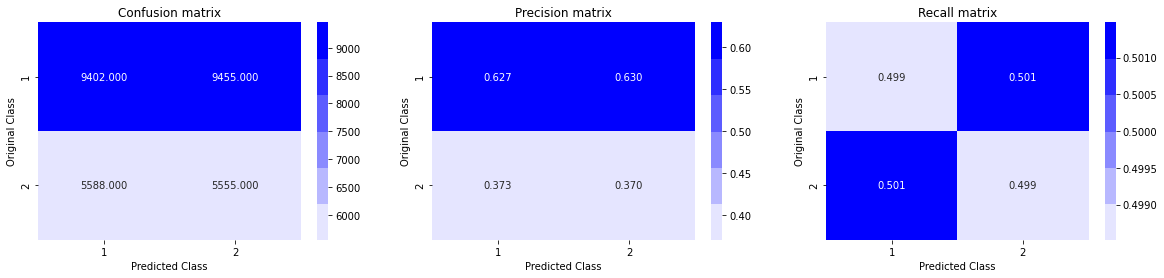

In [78]:
test_len = len(y_test)

# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))
#y_i_hat will be class with higher probability
predicted_y = np.argmax(predicted_y,axis=1)
plot_confusion_matrix(y_test,predicted_y)

#Linear regression with hyperparameter tuning

Linear classifiers (SVM, logistic regression, etc.) with SGD training.

This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning via the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.

This implementation works with data represented as dense or sparse arrays of floating point values for the features. The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM).

In [0]:
x_train.isnull().any()
x_train = x_train.fillna(x_train.median())

In [40]:
x_train.isnull().any()

id           False
qid1         False
qid2         False
freq_qid1    False
freq_qid2    False
             ...  
91_y         False
92_y         False
93_y         False
94_y         False
95_y         False
Length: 221, dtype: bool

In [0]:
x_test = x_test.fillna(x_test.median())

In [42]:
x_test.isnull().any()

id           False
qid1         False
qid2         False
freq_qid1    False
freq_qid2    False
             ...  
91_y         False
92_y         False
93_y         False
94_y         False
95_y         False
Length: 221, dtype: bool

For values of alpha =  1e-05 The log loss is: 0.6597141203361218
For values of alpha =  0.0001 The log loss is: 0.6597141203361218
For values of alpha =  0.001 The log loss is: 0.6597141203361218
For values of alpha =  0.01 The log loss is: 0.6597141203361218
For values of alpha =  0.1 The log loss is: 0.6597141203361218
For values of alpha =  1 The log loss is: 0.5756874716105342
For values of alpha =  10 The log loss is: 0.5637052795269896
For values of alpha =  100 The log loss is: 0.5927713174624891
For values of alpha =  1000 The log loss is: 0.5761588199863117


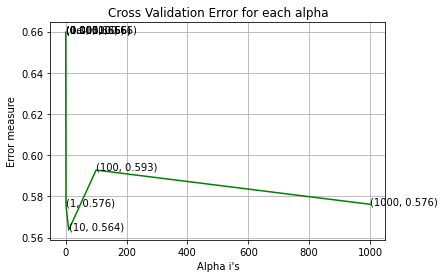

For values of best alpha =  10 The train log loss is: 0.5632712034516045
For values of best alpha =  10 The test log loss is: 0.5637052795269896


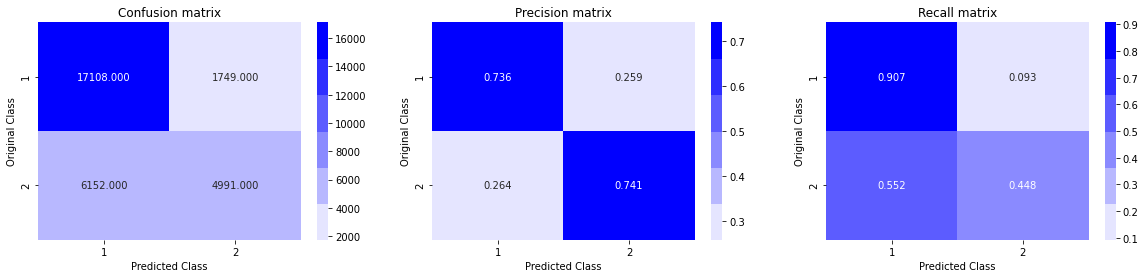

In [91]:
#here we use sgd classifier

# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)


alpha = [10 ** x for x in range(-5,4)] #hyperparameter

log_error_array = []
for i in alpha:
  clf = SGDClassifier(alpha=i , penalty='l2' # L2 regularization
                      , loss = 'log', random_state=42)
  clf.fit(x_train,y_train)
  # as our performance metric is log loss so we need probabilities inside of predicted class label 
  # so in such cases we will have to do calibration of our model
  # When performing classification you often want not only to predict the class label, 
  # but also obtain a probability of the respective label. 
  # This probability gives you some kind of confidence on the prediction. 
  # Some models can give you poor estimates of the class probabilities
  # and some even do not support probability prediction. 
  # The calibration module allows you to better calibrate the probabilities of a given model, 
  # or to add support for probability prediction.
  sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
  #retrain the dataset with calibrated model
  sig_clf.fit(x_train,y_train)
  predicted_y = sig_clf.predict_proba(x_test)
  log_error_array.append(log_loss(y_test,predicted_y,labels=clf.classes_ , eps=1e-15))
  print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predicted_y, labels=clf.classes_, eps=1e-15))
  
#ploting log loss for various values of alpha to find the best alpha
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# best alpha is
best_alpha = np.argmin(log_error_array)
#training the model with the best alpha
clf = SGDClassifier(alpha = alpha[best_alpha] , penalty = 'l2' , loss = 'log' , random_state=42)
clf.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(x_train,y_train)
predicted_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predicted_y, labels=clf.classes_, eps=1e-15))
predicted_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predicted_y, labels=clf.classes_, eps=1e-15))
#predicted_y contains probability values but to plot confusion matrix we need exact predicted class labels so
predicted_y = np.argmax(predicted_y,axis=1)
plot_confusion_matrix(y_test,predicted_y)




#Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.657611721261
For values of alpha =  0.0001 The log loss is: 0.489669093534
For values of alpha =  0.001 The log loss is: 0.521829068562
For values of alpha =  0.01 The log loss is: 0.566295616914
For values of alpha =  0.1 The log loss is: 0.599957866217
For values of alpha =  1 The log loss is: 0.635059427016
For values of alpha =  10 The log loss is: 0.654159467907


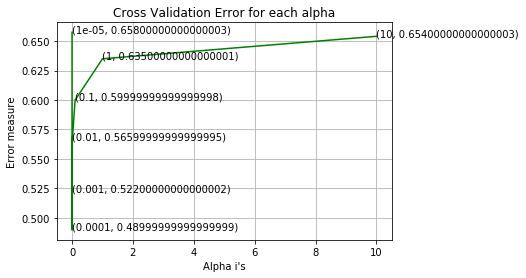

For values of best alpha =  0.0001 The train log loss is: 0.478054677285
For values of best alpha =  0.0001 The test log loss is: 0.489669093534
Total number of data points : 30000


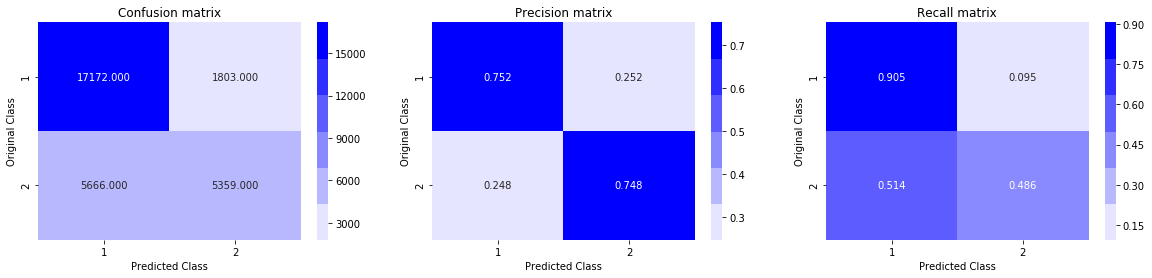

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [0]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684819	valid-logloss:0.684845
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61583	valid-logloss:0.616104
[20]	train-logloss:0.564616	valid-logloss:0.565273
[30]	train-logloss:0.525758	valid-logloss:0.52679
[40]	train-logloss:0.496661	valid-logloss:0.498021
[50]	train-logloss:0.473563	valid-logloss:0.475182
[60]	train-logloss:0.455315	valid-logloss:0.457186
[70]	train-logloss:0.440442	valid-logloss:0.442482
[80]	train-logloss:0.428424	valid-logloss:0.430795
[90]	train-logloss:0.418803	valid-logloss:0.421447
[100]	train-logloss:0.41069	valid-logloss:0.413583
[110]	train-logloss:0.403831	valid-logloss:0.40693
[120]	train-logloss:0.398076	valid-logloss:0.401402
[130]	train-logloss:0.393305	valid-logloss:0.396851
[140]	train-logloss:0.38913	valid-logloss:0.392952
[150]	train-logloss:0.385469	valid-logloss:0.389521
[160]	train-logloss:0.382327	vali

we can also perform hyperparameter tuning on xgboost to get lower value of log loss